In [1]:
import pandas as pd
from os.path import join
import torch
import torch as th
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
!ls /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/

jx			objectRel_pilot_rndembposemb	  output	  xu
objectRel_pilot		objectRelSingle_pilot1		  PixArt-alpha
objectRel_pilot2	objrel2_DiT_B_pilot		  pixart-pokemon
objectRel_pilot_rndemb	objrel_rndembdposemb_DiT_B_pilot  results


In [4]:
figroot = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel2_DiT_B_pilot/cross_attn_vis_figs"

In [5]:
from itertools import product
# you can extend these lists as needed
def generate_test_prompts_collection():
    colors = ['red', 'blue']
    target_shapes = ['square', 'triangle', 'circle']
    verticals = ['above', 'below']
    horizontals = ['to the left of', 'to the right of']
    prompts = []
    for c1, c2 in product(colors, colors):
        if c1 == c2:      # skip same‐color pairs
            continue
        for shape1, shape2 in product(target_shapes, target_shapes):
            if shape1 == shape2:
                continue
            for v in verticals:
                prompts.append(f"{c1} {shape1} is {v} the {c2} {shape2}")
            for h in horizontals:
                prompts.append(f"{c1} {shape1} is {h} the {c2} {shape2}")
            for v, h in product(verticals, horizontals):
                prompts.append(f"{c1} {shape1} is {v} and {h} the {c2} {shape2}")
    return prompts


for prompt in generate_test_prompts_collection():
    print(prompt)

red square is above the blue triangle
red square is below the blue triangle
red square is to the left of the blue triangle
red square is to the right of the blue triangle
red square is above and to the left of the blue triangle
red square is above and to the right of the blue triangle
red square is below and to the left of the blue triangle
red square is below and to the right of the blue triangle
red square is above the blue circle
red square is below the blue circle
red square is to the left of the blue circle
red square is to the right of the blue circle
red square is above and to the left of the blue circle
red square is above and to the right of the blue circle
red square is below and to the left of the blue circle
red square is below and to the right of the blue circle
red triangle is above the blue square
red triangle is below the blue square
red triangle is to the left of the blue square
red triangle is to the right of the blue square
red triangle is above and to the left of th

In [6]:
def generate_test_prompts_collection_and_parsed_words():
    colors = ['red', 'blue']
    target_shapes = ['square', 'triangle', 'circle']
    verticals = ['above', 'below']
    horizontals = ['to the left of', 'to the right of']
    prompts = []
    parsed_words = []
    for c1, c2 in product(colors, colors):
        if c1 == c2:      # skip same‐color pairs
            continue
        for shape1, shape2 in product(target_shapes, target_shapes):
            if shape1 == shape2:
                continue
            for v in verticals:
                prompts.append(f"{c1} {shape1} is {v} the {c2} {shape2}")
                parsed_words.append({"color1": c1, "shape1": shape1, "relation": [v], "color2": c2, "shape2": shape2, "prop": ["is", "the"], "prompt": prompts[-1]})
            for h in horizontals:
                prompts.append(f"{c1} {shape1} is {h} the {c2} {shape2}")
                parsed_words.append({"color1": c1, "shape1": shape1, "relation": [h.split(" ")[2]], "color2": c2, "shape2": shape2, "prop": ["is", "the", "to", "of"], "prompt": prompts[-1]})
            for v, h in product(verticals, horizontals):
                prompts.append(f"{c1} {shape1} is {v} and {h} the {c2} {shape2}")
                parsed_words.append({"color1": c1, "shape1": shape1, "relation": [v, h.split(" ")[2]], "color2": c2, "shape2": shape2, "prop": ["is", "the", "to", "of", "and"], "prompt": prompts[-1]})
    return prompts, parsed_words

In [ ]:
prompts, parsed_words = generate_test_prompts_collection_and_parsed_words()
prompt_df = pd.DataFrame(parsed_words)

In [9]:
prompt_df

,color1,shape1,relation,color2,shape2,prop,prompt
0,red,square,[above],blue,triangle,"[is, the]",red square is above the blue triangle
1,red,square,[below],blue,triangle,"[is, the]",red square is below the blue triangle
2,red,square,[left],blue,triangle,"[is, the, to, of]",red square is to the left of the blue triangle
3,red,square,[right],blue,triangle,"[is, the, to, of]",red square is to the right of the blue triangle
4,red,square,"[above, left]",blue,triangle,"[is, the, to, of, and]",red square is above and to the left of the blu...
...,...,...,...,...,...,...,...
91,blue,circle,[right],red,triangle,"[is, the, to, of]",blue circle is to the right of the red triangle
92,blue,circle,"[above, left]",red,triangle,"[is, the, to, of, and]",blue circle is above and to the left of the re...
93,blue,circle,"[above, right]",red,triangle,"[is, the, to, of, and]",blue circle is above and to the right of the r...
94,blue,circle,"[below, left]",red,triangle,"[is, the, to, of, and]",blue circle is below and to the left of the re...


In [ ]:
# check the prompt decsompose into words in that row. 
prompts, parsed_words = generate_test_prompts_collection_and_parsed_words()
prompt_df = pd.DataFrame(parsed_words)
for i, row in prompt_df.iterrows():
    assert set(row["prompt"].split(" ")) == set(row["prop"]) | set(row["relation"]) | set([row["color1"], row["shape1"], row["color2"], row["shape2"]]), row

In [10]:
row_idx = 0
row = prompt_df.iloc[row_idx]
prompt = row["prompt"]
prompt_dir = join(figroot, prompt.replace(" ", "_"))
img_src = row["shape1"]
text_target = row["relation"][0]
attn_stats_file = join(prompt_dir, f"cross_attn_layer_head_step_stats_image_{img_src}_to_text_{text_target}.pt")
attn_stats = th.load(attn_stats_file)
print(attn_stats.keys())

dict_keys(['cond_stats', 'uncond_stats', 'template_similarity_scores', 'text_mask', 'imgtoken_msk_vec', 'prompt', 'template_type', 'text_targets', 'imgtoken_type'])


/tmp/ipykernel_643665/2334892210.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  attn_stats = th.load(attn_stats_file)


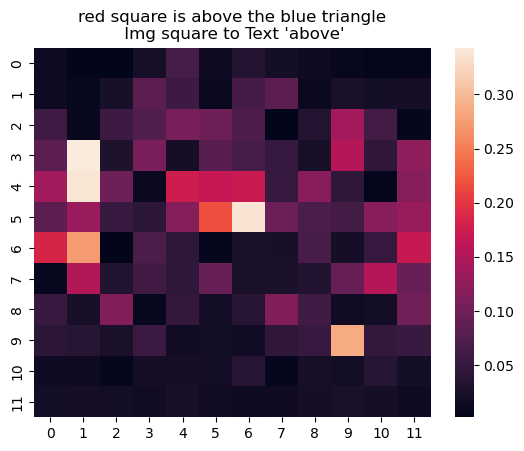

In [11]:

sns.heatmap(attn_stats["cond_stats"])
plt.title(f"{prompt}\n Img {img_src} to Text '{text_target}'")
plt.show()

### Prompt split

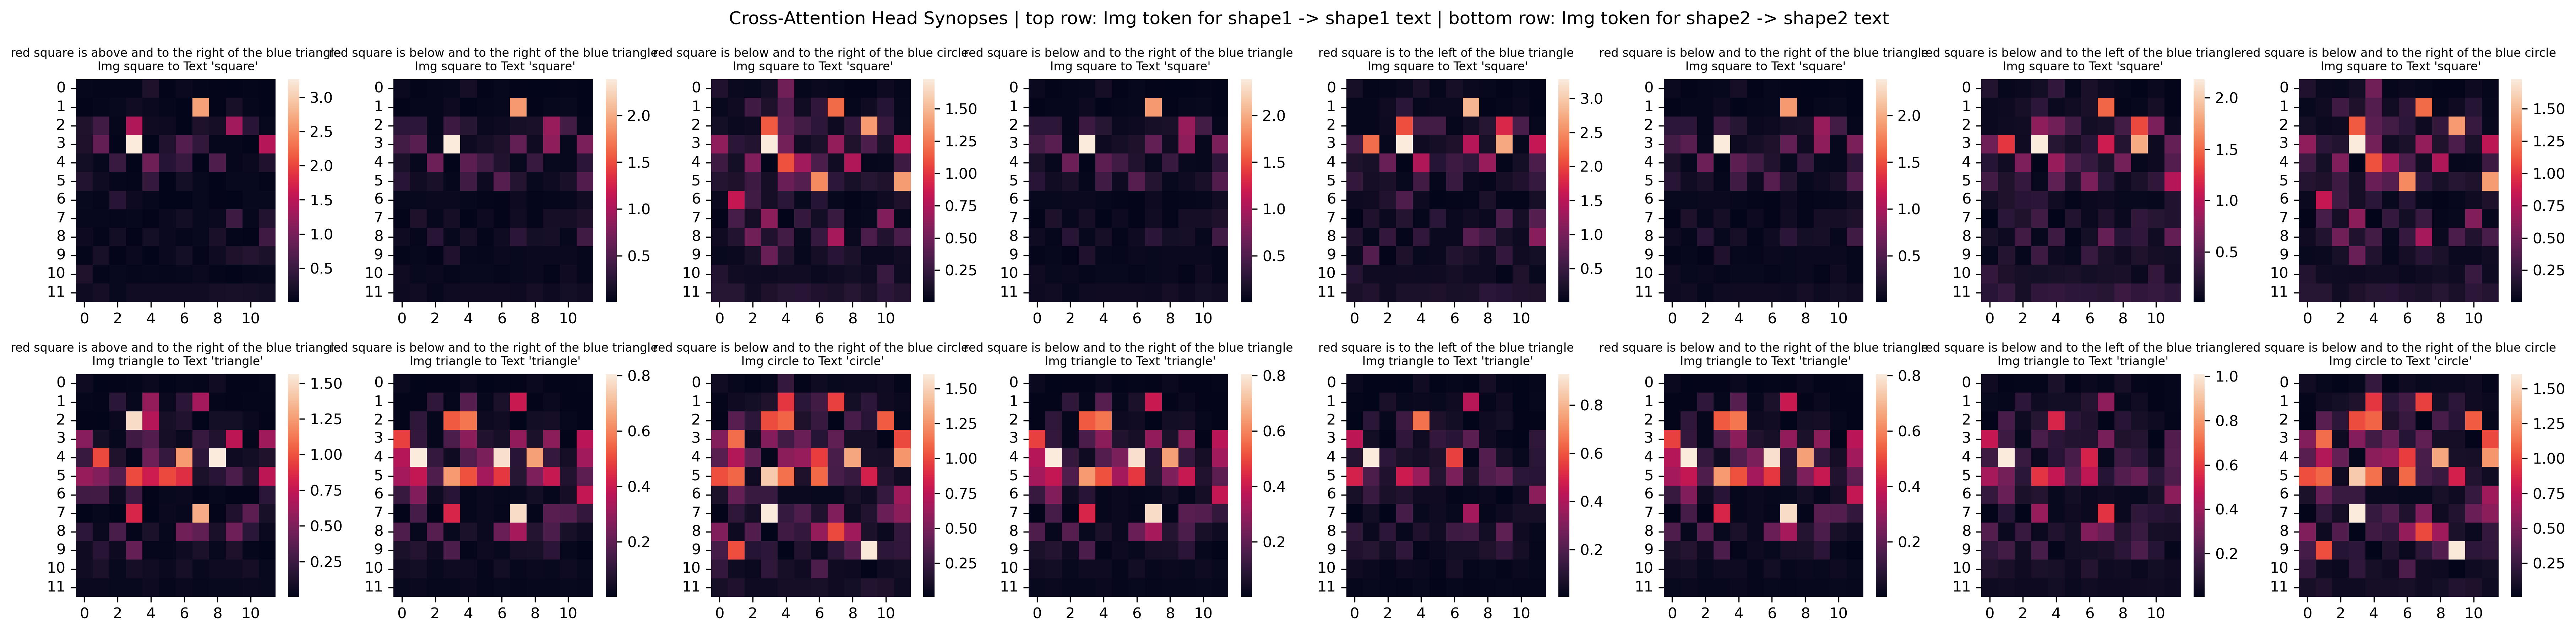

In [12]:
# row_idx = 0
prompt_part_df = prompt_df.query("shape1 == 'square' and color1 == 'red'")
fig, axs = plt.subplots(2, 8, figsize=(24, 6), dpi=300)
for idx in range(8):
    r_idx = np.random.randint(0, len(prompt_part_df))
    row = prompt_part_df.iloc[r_idx]
    prompt = row["prompt"]
    prompt_dir = join(figroot, prompt.replace(" ", "_"))
    img_src = row["shape1"]
    text_target = row["shape1"]
    attn_stats_file = join(prompt_dir, f"cross_attn_layer_head_step_stats_image_{img_src}_to_text_{text_target}.pt")
    attn_stats = th.load(attn_stats_file, weights_only=False)
    plt.sca(axs[0, idx])
    sns.heatmap(attn_stats["cond_stats"])
    plt.title(f"{prompt}\n Img {img_src} to Text '{text_target}'", fontsize=8)
    plt.sca(axs[1, idx])
    img_src = row["shape2"]
    text_target = row["shape2"]
    attn_stats_file = join(prompt_dir, f"cross_attn_layer_head_step_stats_image_{img_src}_to_text_{text_target}.pt")
    attn_stats = th.load(attn_stats_file, weights_only=False)
    sns.heatmap(attn_stats["cond_stats"])
    plt.title(f"{prompt}\n Img {img_src} to Text '{text_target}'", fontsize=8)
plt.suptitle("Cross-Attention Head Synopses | top row: Img token for shape1 -> shape1 text | bottom row: Img token for shape2 -> shape2 text", fontsize=12)
plt.tight_layout()
plt.show()

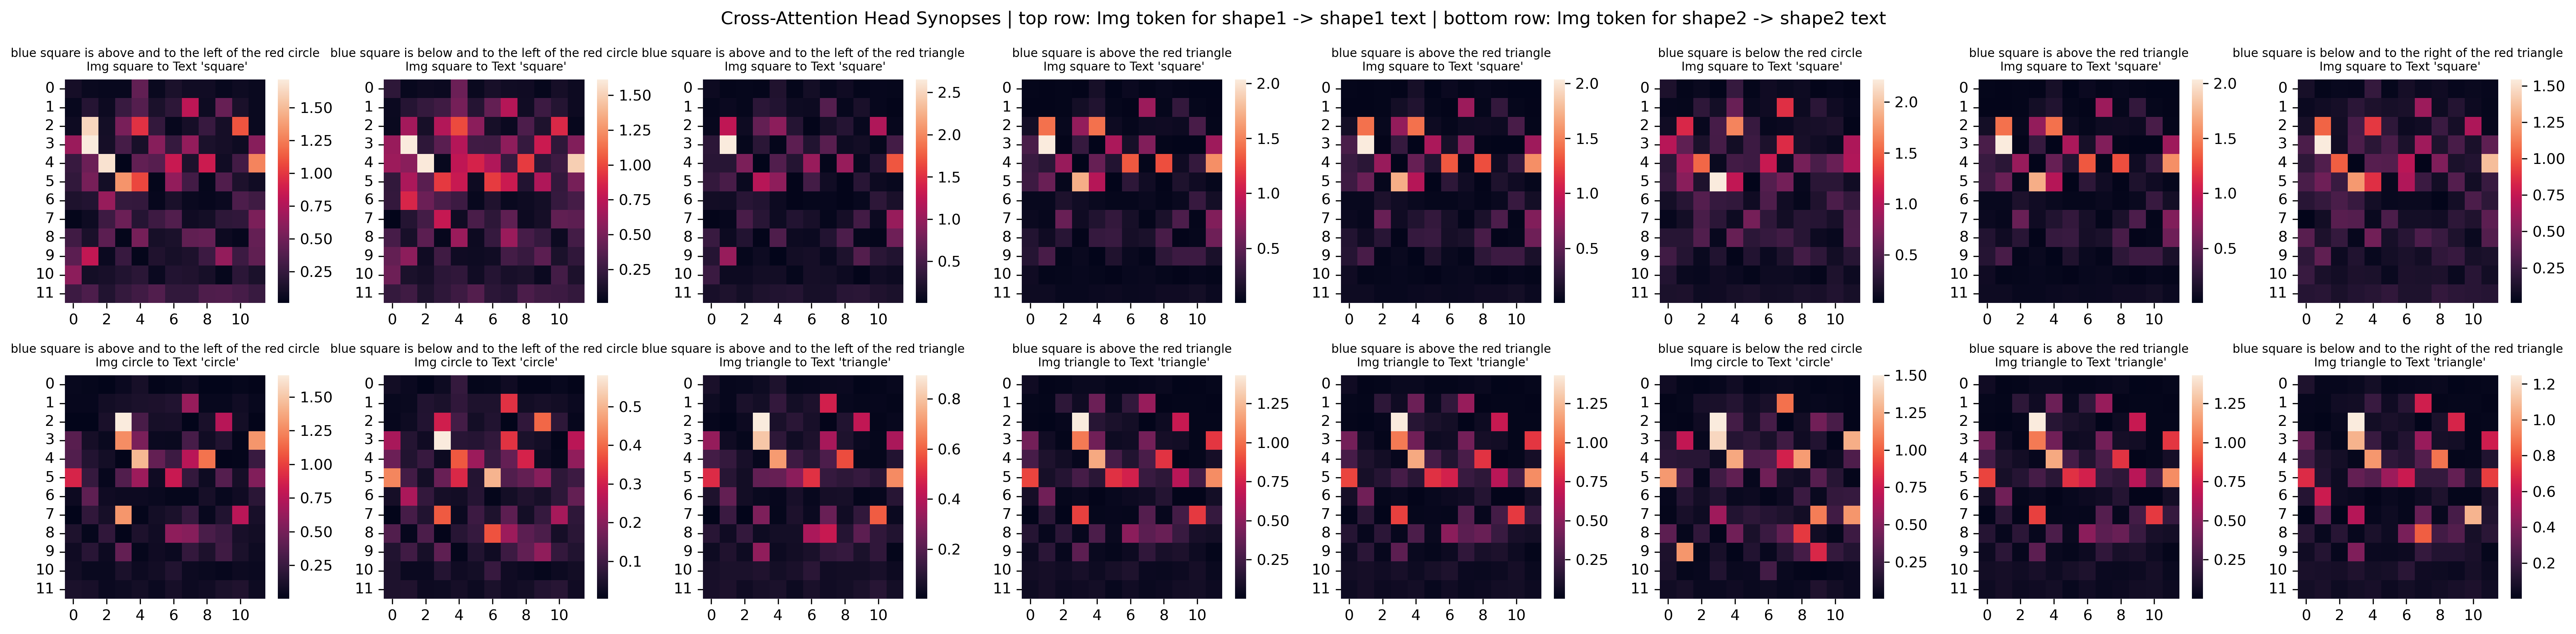

In [13]:
# row_idx = 0
prompt_part_df = prompt_df.query("shape1 == 'square' and color1 == 'blue'")
fig, axs = plt.subplots(2, 8, figsize=(24, 6), dpi=300)
for idx in range(8):
    r_idx = np.random.randint(0, len(prompt_part_df))
    row = prompt_part_df.iloc[r_idx]
    prompt = row["prompt"]
    prompt_dir = join(figroot, prompt.replace(" ", "_"))
    img_src = row["shape1"]
    text_target = row["shape1"]
    attn_stats_file = join(prompt_dir, f"cross_attn_layer_head_step_stats_image_{img_src}_to_text_{text_target}.pt")
    attn_stats = th.load(attn_stats_file, weights_only=False)
    plt.sca(axs[0, idx])
    sns.heatmap(attn_stats["cond_stats"])
    plt.title(f"{prompt}\n Img {img_src} to Text '{text_target}'", fontsize=8)
    plt.sca(axs[1, idx])
    img_src = row["shape2"]
    text_target = row["shape2"]
    attn_stats_file = join(prompt_dir, f"cross_attn_layer_head_step_stats_image_{img_src}_to_text_{text_target}.pt")
    attn_stats = th.load(attn_stats_file, weights_only=False)
    sns.heatmap(attn_stats["cond_stats"])
    plt.title(f"{prompt}\n Img {img_src} to Text '{text_target}'", fontsize=8)
plt.suptitle("Cross-Attention Head Synopses | top row: Img token for shape1 -> shape1 text | bottom row: Img token for shape2 -> shape2 text", fontsize=12)
plt.tight_layout()
plt.show()

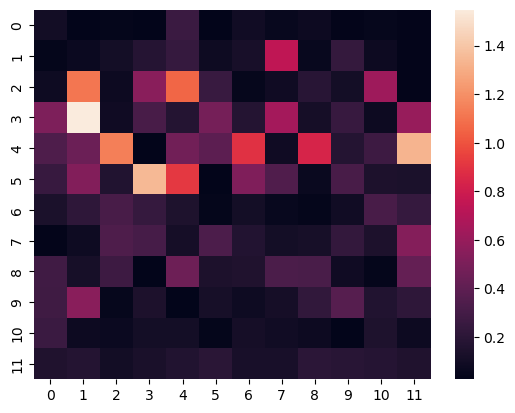

In [14]:
prompt_part_df = prompt_df.query("shape1 == 'square' and color1 == 'blue'")
cond_stats_list = []
for r_idx in range(len(prompt_part_df)):
    row = prompt_part_df.iloc[r_idx]
    prompt = row["prompt"]
    prompt_dir = join(figroot, prompt.replace(" ", "_"))
    img_src = row["shape1"]
    text_target = row["shape1"]
    attn_stats_file = join(prompt_dir, f"cross_attn_layer_head_step_stats_image_{img_src}_to_text_{text_target}.pt")
    attn_stats = th.load(attn_stats_file, weights_only=False)
    cond_stats = attn_stats["cond_stats"]
    cond_stats_list.append(cond_stats)

cond_stats_array = np.stack(cond_stats_list, axis=0)
sns.heatmap(cond_stats_array.mean(axis=0))
plt.show()

### Summary across prompt partition: Object -> corresponding shape

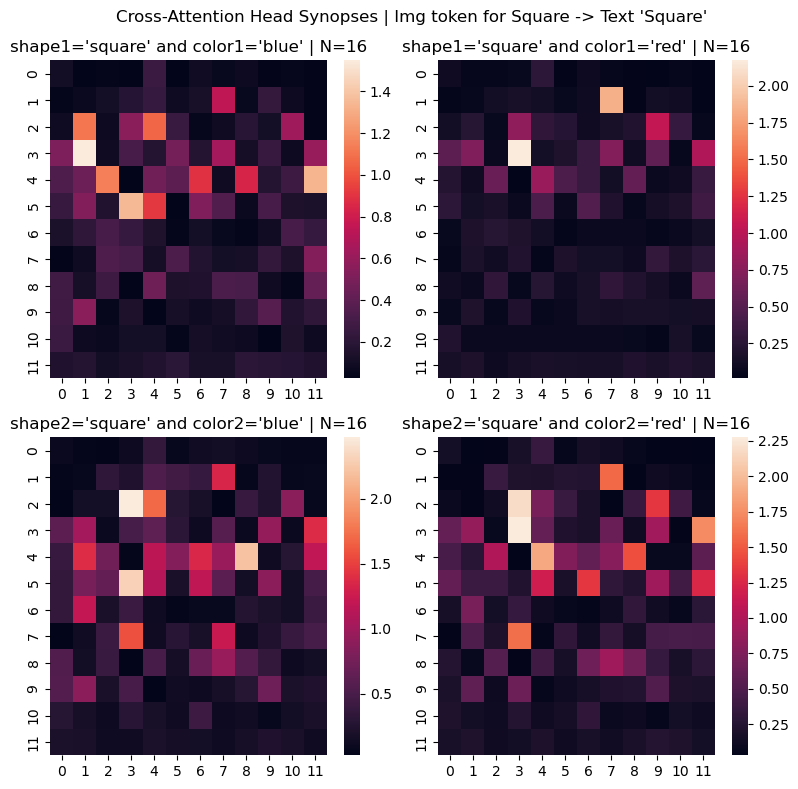

In [18]:
img_src_str = "square"
text_target_str = "square"
fig, axs = plt.subplots(2, 2, figsize=(8, 8), )
axs = axs.flatten()
for query_idx, query_str in enumerate([
    "shape1 == 'square' and color1 == 'blue'",
    "shape1 == 'square' and color1 == 'red'",
    "shape2 == 'square' and color2 == 'blue'",
    "shape2 == 'square' and color2 == 'red'",
]):
    prompt_part_df = prompt_df.query(query_str)
    cond_stats_list = []
    for r_idx in range(len(prompt_part_df)):
        row = prompt_part_df.iloc[r_idx]
        prompt = row["prompt"]
        img_src = row[img_src_str] if img_src_str in row.keys() else img_src_str
        text_target = row[text_target_str] if text_target_str in row.keys() else text_target_str
        prompt_dir = join(figroot, prompt.replace(" ", "_"))
        attn_stats_file = join(prompt_dir, f"cross_attn_layer_head_step_stats_image_{img_src}_to_text_{text_target}.pt")
        attn_stats = th.load(attn_stats_file, weights_only=False)
        cond_stats = attn_stats["cond_stats"]
        cond_stats_list.append(cond_stats)

    cond_stats_array = np.stack(cond_stats_list, axis=0)
    plt.sca(axs[query_idx])
    sns.heatmap(cond_stats_array.mean(axis=0))
    plt.title(f"{query_str.replace(' == ', '=')} | N={len(prompt_part_df)}")
plt.suptitle("Cross-Attention Head Synopses | Img token for Square -> Text 'Square'", fontsize=12)
plt.tight_layout()
plt.show()

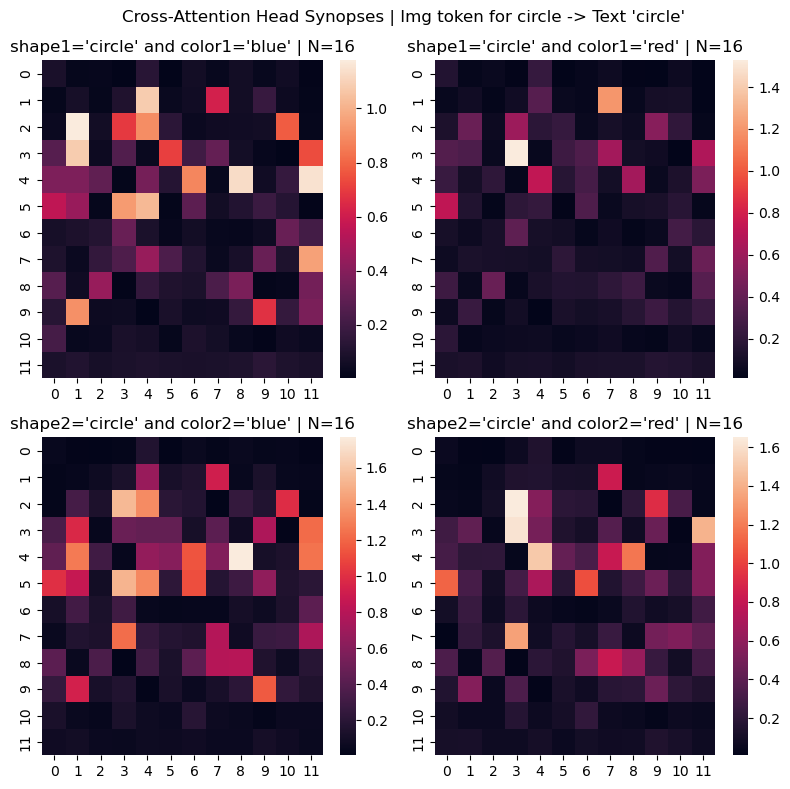

In [19]:
img_src_str = "circle"
text_target_str = "circle"
fig, axs = plt.subplots(2, 2, figsize=(8, 8), )
axs = axs.flatten()
for query_idx, query_str in enumerate([
    "shape1 == 'circle' and color1 == 'blue'",
    "shape1 == 'circle' and color1 == 'red'",
    "shape2 == 'circle' and color2 == 'blue'",
    "shape2 == 'circle' and color2 == 'red'",
]):
    prompt_part_df = prompt_df.query(query_str)
    cond_stats_list = []
    for r_idx in range(len(prompt_part_df)):
        row = prompt_part_df.iloc[r_idx]
        prompt = row["prompt"]
        img_src = row[img_src_str] if img_src_str in row.keys() else img_src_str
        text_target = row[text_target_str] if text_target_str in row.keys() else text_target_str
        prompt_dir = join(figroot, prompt.replace(" ", "_"))
        attn_stats_file = join(prompt_dir, f"cross_attn_layer_head_step_stats_image_{img_src}_to_text_{text_target}.pt")
        attn_stats = th.load(attn_stats_file, weights_only=False)
        cond_stats = attn_stats["cond_stats"]
        cond_stats_list.append(cond_stats)

    cond_stats_array = np.stack(cond_stats_list, axis=0)
    plt.sca(axs[query_idx])
    sns.heatmap(cond_stats_array.mean(axis=0))
    plt.title(f"{query_str.replace(' == ', '=')} | N={len(prompt_part_df)}")
plt.suptitle("Cross-Attention Head Synopses | Img token for circle -> Text 'circle'", fontsize=12)
plt.tight_layout()
plt.show()

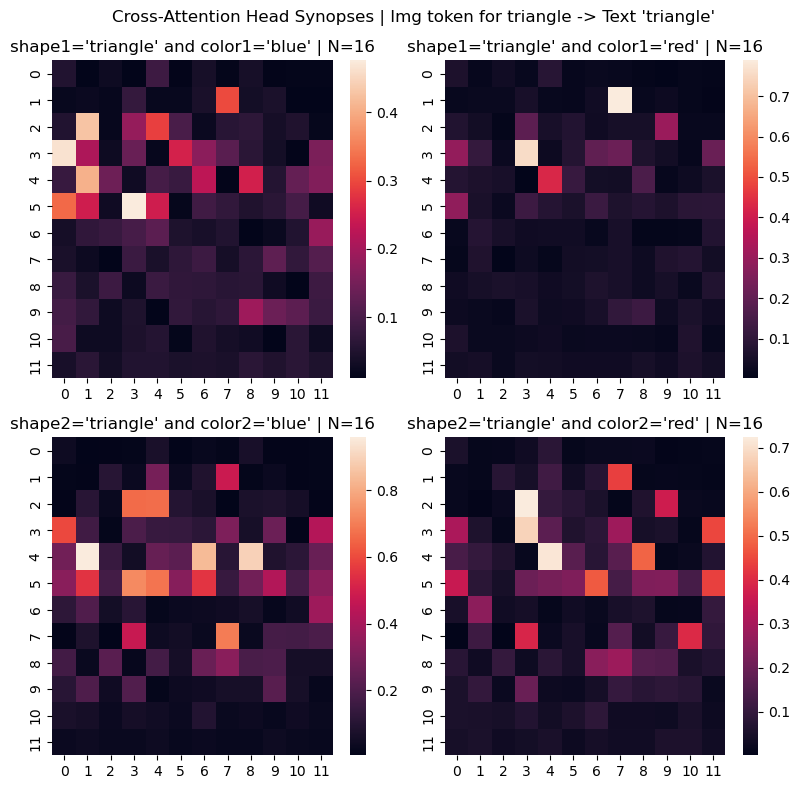

In [20]:
img_src_str = "triangle"
text_target_str = "triangle"
fig, axs = plt.subplots(2, 2, figsize=(8, 8), )
axs = axs.flatten()
for query_idx, query_str in enumerate([
    "shape1 == 'triangle' and color1 == 'blue'",
    "shape1 == 'triangle' and color1 == 'red'",
    "shape2 == 'triangle' and color2 == 'blue'",
    "shape2 == 'triangle' and color2 == 'red'",
]):
    prompt_part_df = prompt_df.query(query_str)
    cond_stats_list = []
    for r_idx in range(len(prompt_part_df)):
        row = prompt_part_df.iloc[r_idx]
        prompt = row["prompt"]
        img_src = row[img_src_str] if img_src_str in row.keys() else img_src_str
        text_target = row[text_target_str] if text_target_str in row.keys() else text_target_str
        prompt_dir = join(figroot, prompt.replace(" ", "_"))
        attn_stats_file = join(prompt_dir, f"cross_attn_layer_head_step_stats_image_{img_src}_to_text_{text_target}.pt")
        attn_stats = th.load(attn_stats_file, weights_only=False)
        cond_stats = attn_stats["cond_stats"]
        cond_stats_list.append(cond_stats)

    cond_stats_array = np.stack(cond_stats_list, axis=0)
    plt.sca(axs[query_idx])
    sns.heatmap(cond_stats_array.mean(axis=0))
    plt.title(f"{query_str.replace(' == ', '=')} | N={len(prompt_part_df)}")
plt.suptitle("Cross-Attention Head Synopses | Img token for triangle -> Text 'triangle'", fontsize=12)
plt.tight_layout()
plt.show()

### Object to relation words

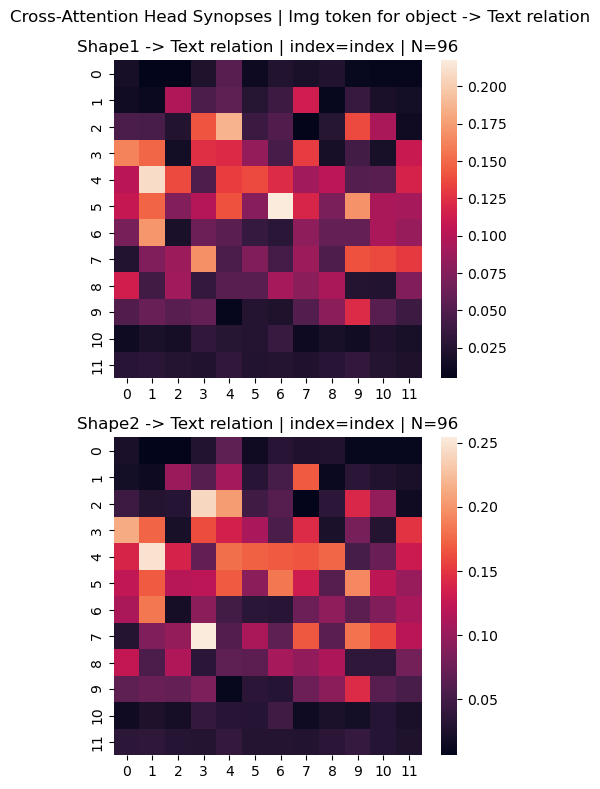

In [21]:
# img_src_str = "shape1"
# text_target_str = "relation"
fig, axs = plt.subplots(2, 1, figsize=(4.5, 8), squeeze=False)

for src_idx, img_src_str in enumerate(["shape1", "shape2"]):
    for query_idx, query_str in enumerate([
        "index == index",
    ]):
        prompt_part_df = prompt_df.query(query_str)
        cond_stats_list = []
        for r_idx in range(len(prompt_part_df)):
            row = prompt_part_df.iloc[r_idx]
            prompt = row["prompt"]
            img_src = row[img_src_str] if img_src_str in row.keys() else img_src_str
            # text_target = row[text_target_str] if text_target_str in row.keys() else text_target_str
            text_target = row["relation"][-1] 
            prompt_dir = join(figroot, prompt.replace(" ", "_"))
            attn_stats_file = join(prompt_dir, f"cross_attn_layer_head_step_stats_image_{img_src}_to_text_{text_target}.pt")
            attn_stats = th.load(attn_stats_file, weights_only=False)
            cond_stats = attn_stats["cond_stats"]
            cond_stats_list.append(cond_stats)

        cond_stats_array = np.stack(cond_stats_list, axis=0)
        plt.sca(axs[src_idx, query_idx])
        sns.heatmap(cond_stats_array.mean(axis=0))
        if src_idx == 0:
            plt.title(f"Shape1 -> Text relation | {query_str.replace(' == ', '=')} | N={len(prompt_part_df)}")
        else:
            plt.title(f"Shape2 -> Text relation | {query_str.replace(' == ', '=')} | N={len(prompt_part_df)}")
plt.suptitle("Cross-Attention Head Synopses | Img token for object -> Text relation", fontsize=12)
plt.tight_layout()
plt.show()

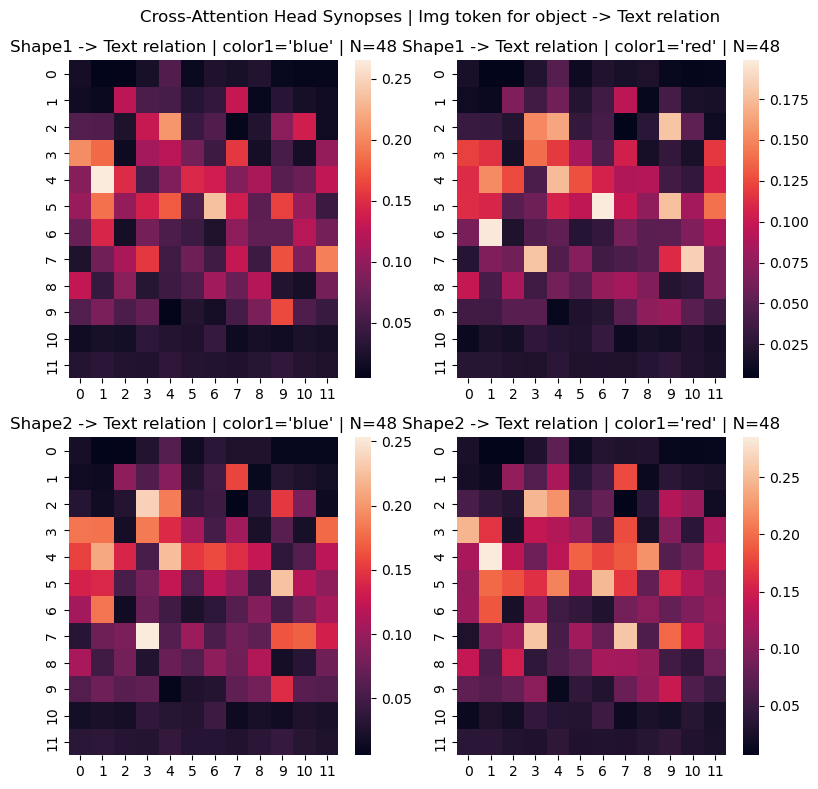

In [22]:
# img_src_str = "shape1"
# text_target_str = "relation"
fig, axs = plt.subplots(2, 2, figsize=(8, 8), )

for src_idx, img_src_str in enumerate(["shape1", "shape2"]):
    for query_idx, query_str in enumerate([
        "color1 == 'blue'",
        "color1 == 'red'",
    ]):
        prompt_part_df = prompt_df.query(query_str)
        cond_stats_list = []
        for r_idx in range(len(prompt_part_df)):
            row = prompt_part_df.iloc[r_idx]
            prompt = row["prompt"]
            img_src = row[img_src_str] if img_src_str in row.keys() else img_src_str
            # text_target = row[text_target_str] if text_target_str in row.keys() else text_target_str
            text_target = row["relation"][-1] 
            prompt_dir = join(figroot, prompt.replace(" ", "_"))
            attn_stats_file = join(prompt_dir, f"cross_attn_layer_head_step_stats_image_{img_src}_to_text_{text_target}.pt")
            attn_stats = th.load(attn_stats_file, weights_only=False)
            cond_stats = attn_stats["cond_stats"]
            cond_stats_list.append(cond_stats)

        cond_stats_array = np.stack(cond_stats_list, axis=0)
        plt.sca(axs[src_idx, query_idx])
        sns.heatmap(cond_stats_array.mean(axis=0))
        if src_idx == 0:
            plt.title(f"Shape1 -> Text relation | {query_str.replace(' == ', '=')} | N={len(prompt_part_df)}")
        else:
            plt.title(f"Shape2 -> Text relation | {query_str.replace(' == ', '=')} | N={len(prompt_part_df)}")
plt.suptitle("Cross-Attention Head Synopses | Img token for object -> Text relation", fontsize=12)
plt.tight_layout()
plt.show()

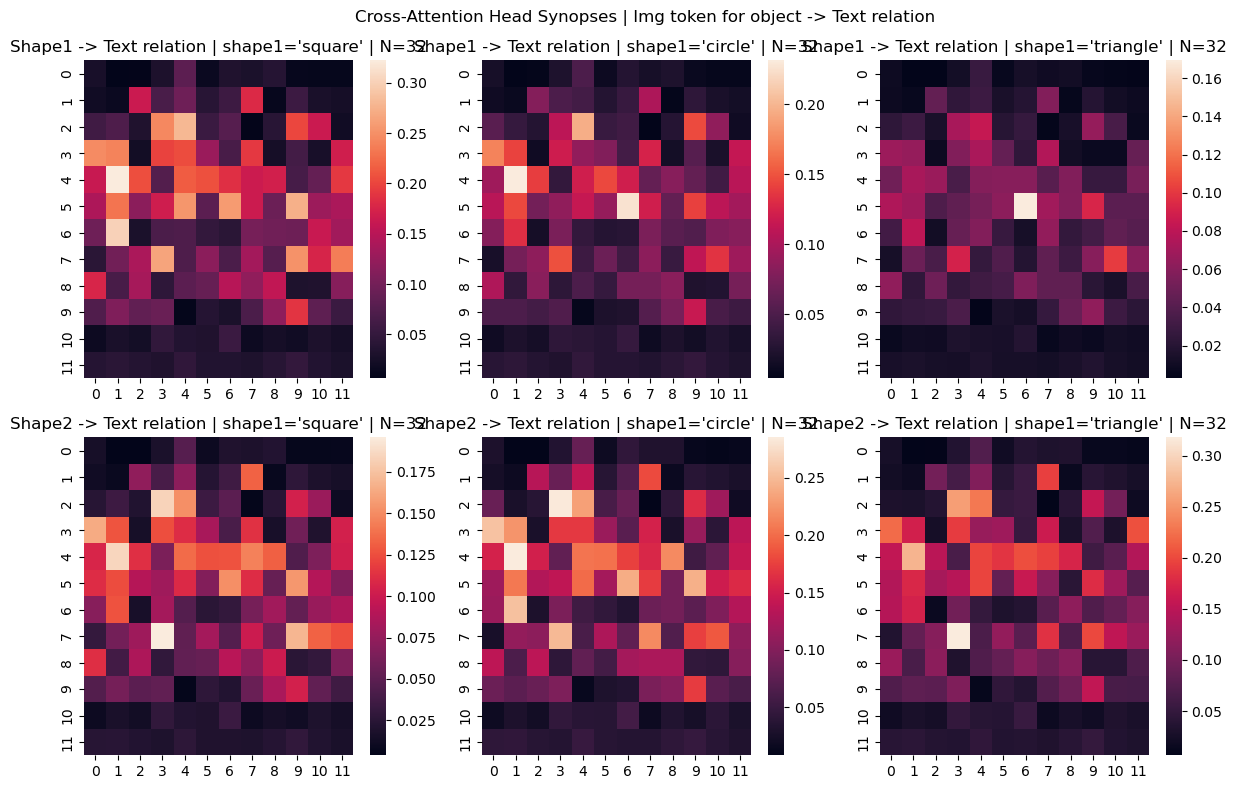

In [23]:
# img_src_str = "shape1"
# text_target_str = "relation"
fig, axs = plt.subplots(2, 3, figsize=(12, 8), )

for src_idx, img_src_str in enumerate(["shape1", "shape2"]):
    for query_idx, query_str in enumerate([
        "shape1 == 'square'",
        "shape1 == 'circle'",
        "shape1 == 'triangle'",
    ]):
        prompt_part_df = prompt_df.query(query_str)
        cond_stats_list = []
        for r_idx in range(len(prompt_part_df)):
            row = prompt_part_df.iloc[r_idx]
            prompt = row["prompt"]
            img_src = row[img_src_str] if img_src_str in row.keys() else img_src_str
            # text_target = row[text_target_str] if text_target_str in row.keys() else text_target_str
            text_target = row["relation"][-1] 
            prompt_dir = join(figroot, prompt.replace(" ", "_"))
            attn_stats_file = join(prompt_dir, f"cross_attn_layer_head_step_stats_image_{img_src}_to_text_{text_target}.pt")
            attn_stats = th.load(attn_stats_file, weights_only=False)
            cond_stats = attn_stats["cond_stats"]
            cond_stats_list.append(cond_stats)

        cond_stats_array = np.stack(cond_stats_list, axis=0)
        plt.sca(axs[src_idx, query_idx])
        sns.heatmap(cond_stats_array.mean(axis=0))
        if src_idx == 0:
            plt.title(f"Shape1 -> Text relation | {query_str.replace(' == ', '=')} | N={len(prompt_part_df)}")
        else:
            plt.title(f"Shape2 -> Text relation | {query_str.replace(' == ', '=')} | N={len(prompt_part_df)}")
plt.suptitle("Cross-Attention Head Synopses | Img token for object -> Text relation", fontsize=12)
plt.tight_layout()
plt.show()

In [24]:
prompt_df["relation"] = prompt_df.relation.apply(lambda x: tuple(x))
prompt_df["relation_str"] = prompt_df.relation.apply(lambda x: "_".join(x))

In [25]:
prompt_df.relation_str.unique()

array(['above', 'below', 'left', 'right', 'above_left', 'above_right',
       'below_left', 'below_right'], dtype=object)

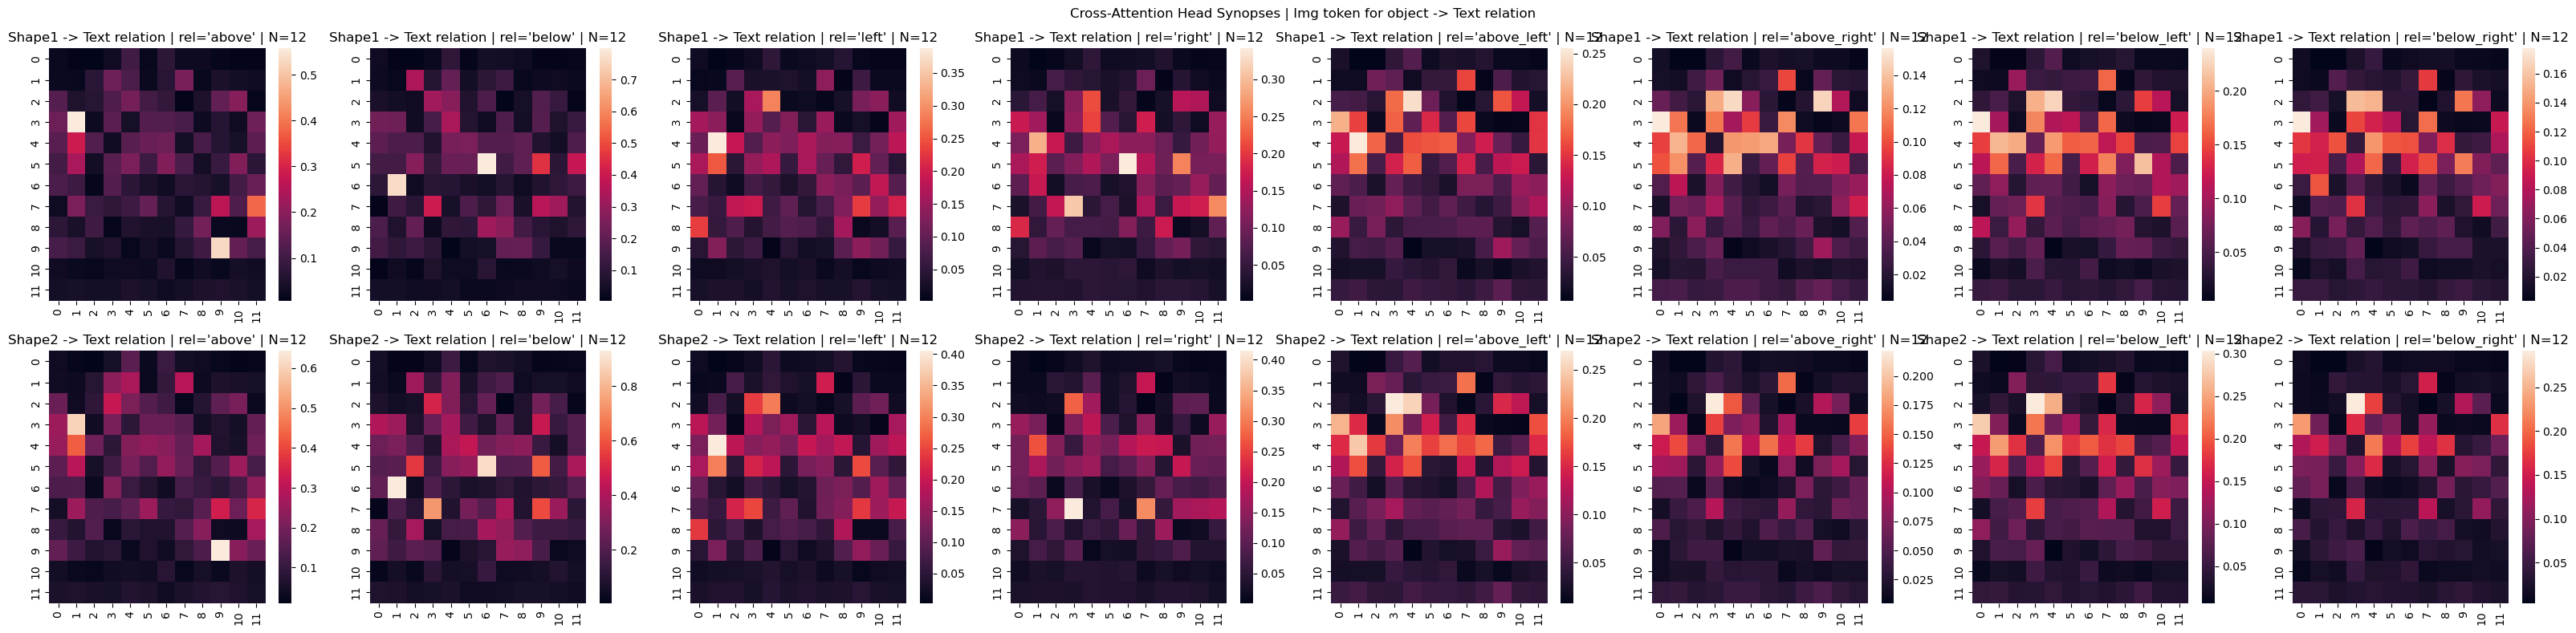

In [29]:
# img_src_str = "shape1"
# text_target_str = "relation"
fig, axs = plt.subplots(2, 8, figsize=(32, 8), )
for src_idx, img_src_str in enumerate(["shape1", "shape2"]):
    for query_idx, query_str in enumerate([
        "relation_str == 'above'",
        "relation_str == 'below'",
        "relation_str == 'left'",
        "relation_str == 'right'",
        "relation_str == 'above_left'",
        "relation_str == 'above_right'",
        "relation_str == 'below_left'",
        "relation_str == 'below_right'",
    ]):
        prompt_part_df = prompt_df.query(query_str)
        cond_stats_list = []
        for r_idx in range(len(prompt_part_df)):
            row = prompt_part_df.iloc[r_idx]
            prompt = row["prompt"]
            img_src = row[img_src_str] if img_src_str in row.keys() else img_src_str
            # text_target = row[text_target_str] if text_target_str in row.keys() else text_target_str
            text_target = "_".join(["below", "left", "top", "right", "above"]) #row["relation"][-1] 
            prompt_dir = join(figroot, prompt.replace(" ", "_"))
            attn_stats_file = join(prompt_dir, f"cross_attn_layer_head_step_stats_image_{img_src}_to_text_{text_target}.pt")
            attn_stats = th.load(attn_stats_file, weights_only=False)
            cond_stats = attn_stats["cond_stats"]
            cond_stats_list.append(cond_stats)

        cond_stats_array = np.stack(cond_stats_list, axis=0)
        plt.sca(axs[src_idx, query_idx])
        sns.heatmap(cond_stats_array.mean(axis=0))
        if src_idx == 0:
            plt.title(f"Shape1 -> Text relation | {query_str.replace(' == ', '=').replace('relation_str','rel')} | N={len(prompt_part_df)}")
        else:
            plt.title(f"Shape2 -> Text relation | {query_str.replace(' == ', '=').replace('relation_str','rel')} | N={len(prompt_part_df)}")
plt.suptitle("Cross-Attention Head Synopses | Img token for object -> Text relation", fontsize=12)
plt.tight_layout()
plt.show()

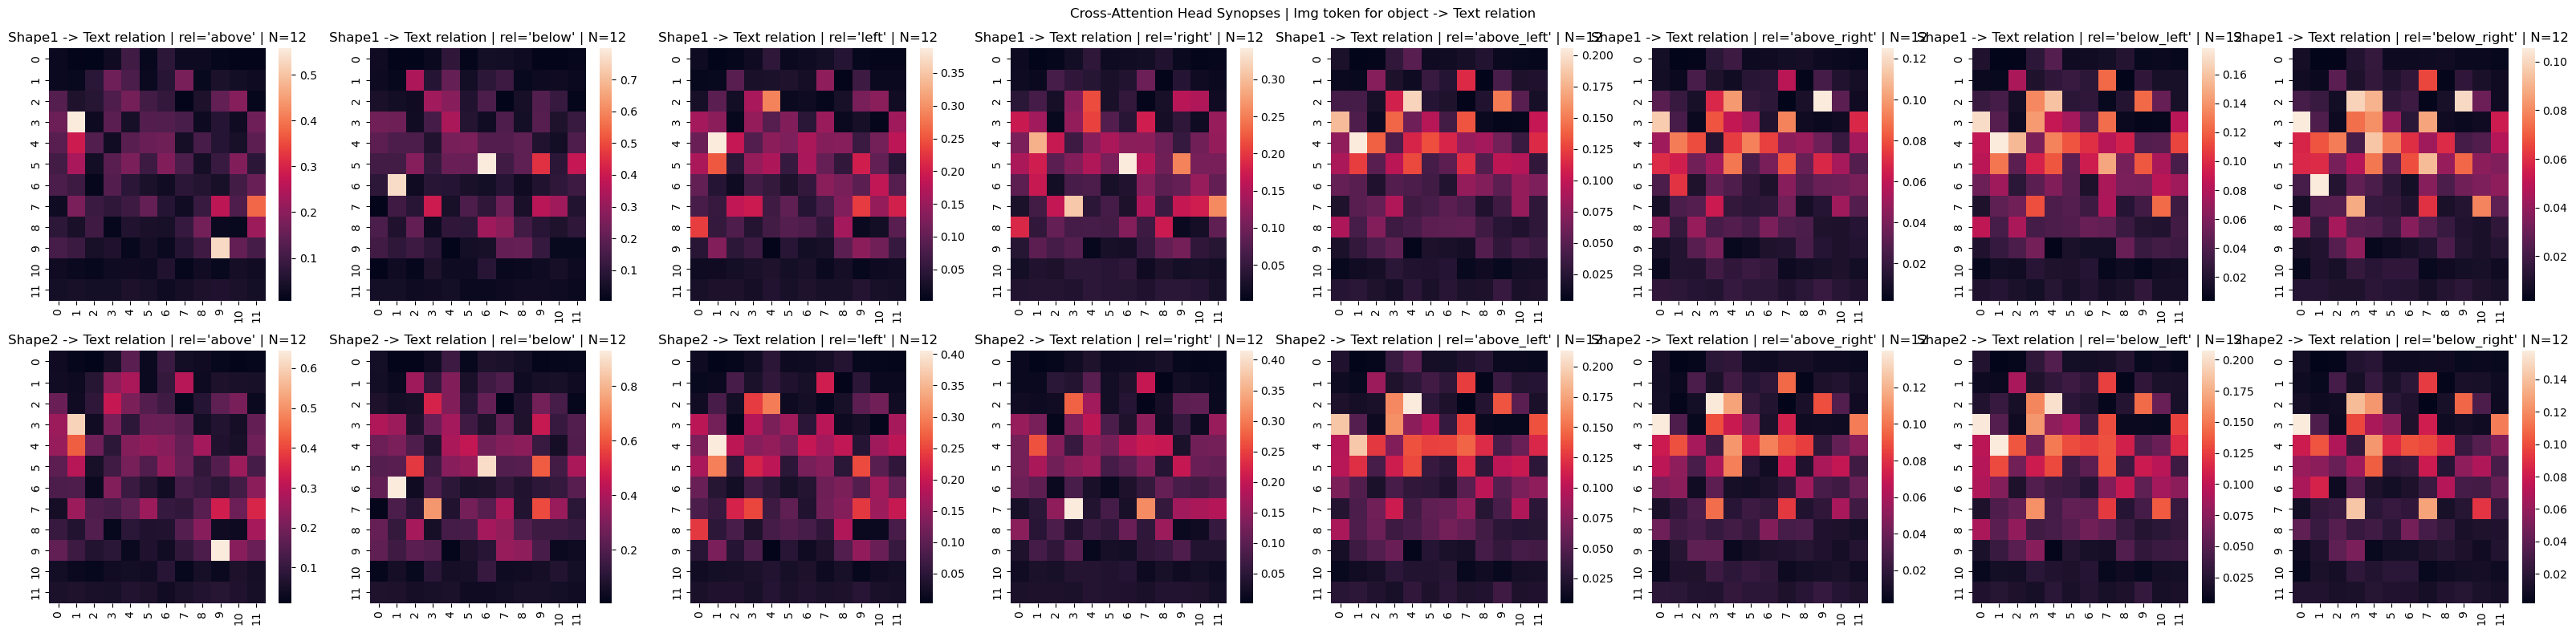

In [30]:
# img_src_str = "shape1"
# text_target_str = "relation"
fig, axs = plt.subplots(2, 8, figsize=(32, 8), )
for src_idx, img_src_str in enumerate(["shape1", "shape2"]):
    for query_idx, query_str in enumerate([
        "relation_str == 'above'",
        "relation_str == 'below'",
        "relation_str == 'left'",
        "relation_str == 'right'",
        "relation_str == 'above_left'",
        "relation_str == 'above_right'",
        "relation_str == 'below_left'",
        "relation_str == 'below_right'",
    ]):
        prompt_part_df = prompt_df.query(query_str)
        cond_stats_list = []
        for r_idx in range(len(prompt_part_df)):
            row = prompt_part_df.iloc[r_idx]
            prompt = row["prompt"]
            img_src = row[img_src_str] if img_src_str in row.keys() else img_src_str
            # text_target = row[text_target_str] if text_target_str in row.keys() else text_target_str
            text_target = row["relation"][-1] # "_".join(["below", "left", "top", "right", "above"]) #
            prompt_dir = join(figroot, prompt.replace(" ", "_"))
            attn_stats_file = join(prompt_dir, f"cross_attn_layer_head_step_stats_image_{img_src}_to_text_{text_target}.pt")
            attn_stats = th.load(attn_stats_file, weights_only=False)
            cond_stats = attn_stats["cond_stats"]
            cond_stats_list.append(cond_stats)

        cond_stats_array = np.stack(cond_stats_list, axis=0)
        plt.sca(axs[src_idx, query_idx])
        sns.heatmap(cond_stats_array.mean(axis=0))
        if src_idx == 0:
            plt.title(f"Shape1 -> Text relation | {query_str.replace(' == ', '=').replace('relation_str','rel')} | N={len(prompt_part_df)}")
        else:
            plt.title(f"Shape2 -> Text relation | {query_str.replace(' == ', '=').replace('relation_str','rel')} | N={len(prompt_part_df)}")
plt.suptitle("Cross-Attention Head Synopses | Img token for object -> Text relation", fontsize=12)
plt.tight_layout()
plt.show()

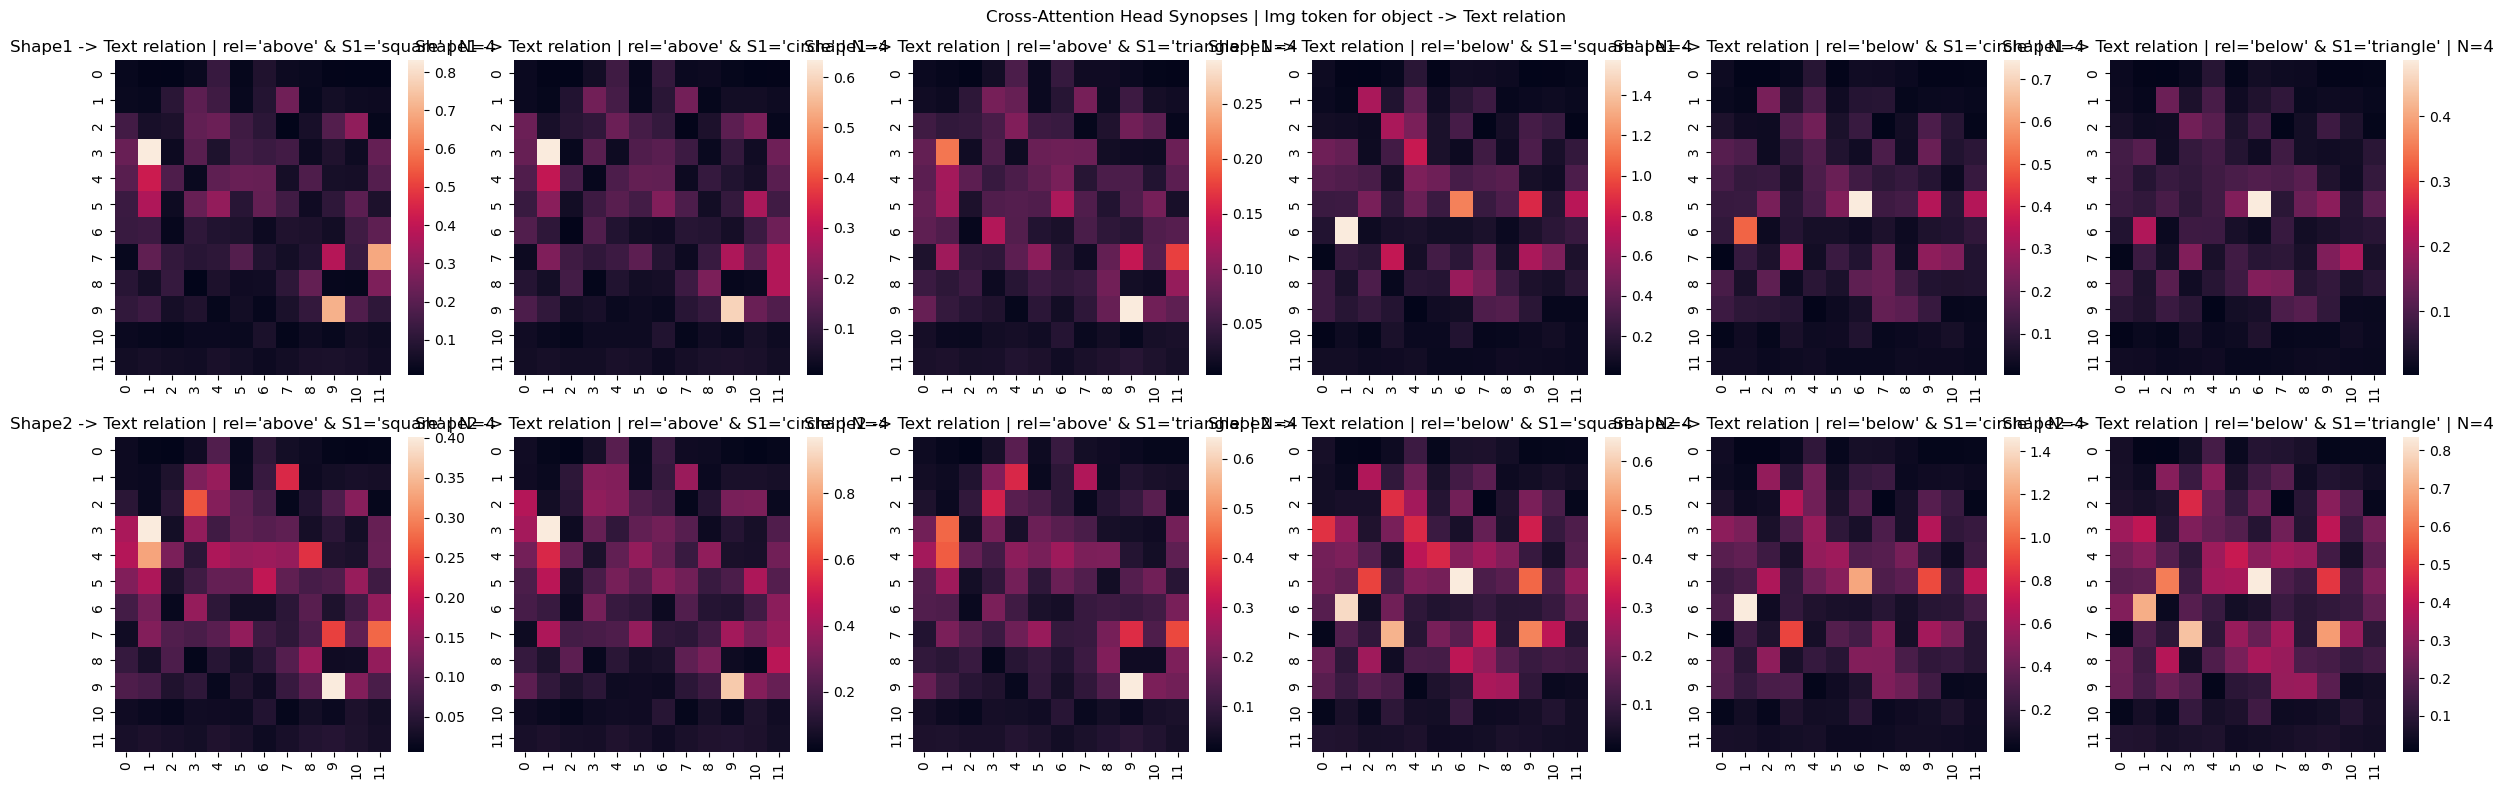

In [33]:
# img_src_str = "shape1"
# text_target_str = "relation"
fig, axs = plt.subplots(2, 6, figsize=(24, 8), )
for src_idx, img_src_str in enumerate(["shape1", "shape2"]):
    for query_idx, query_str in enumerate([
        "relation_str == 'above' and shape1 == 'square'",
        "relation_str == 'above' and shape1 == 'circle'",
        "relation_str == 'above' and shape1 == 'triangle'",
        "relation_str == 'below' and shape1 == 'square'",
        "relation_str == 'below' and shape1 == 'circle'",
        "relation_str == 'below' and shape1 == 'triangle'",
    ]):
        prompt_part_df = prompt_df.query(query_str)
        cond_stats_list = []
        for r_idx in range(len(prompt_part_df)):
            row = prompt_part_df.iloc[r_idx]
            prompt = row["prompt"]
            img_src = row[img_src_str] if img_src_str in row.keys() else img_src_str
            # text_target = row[text_target_str] if text_target_str in row.keys() else text_target_str
            text_target = row["relation"][-1] # "_".join(["below", "left", "top", "right", "above"]) #
            prompt_dir = join(figroot, prompt.replace(" ", "_"))
            attn_stats_file = join(prompt_dir, f"cross_attn_layer_head_step_stats_image_{img_src}_to_text_{text_target}.pt")
            attn_stats = th.load(attn_stats_file, weights_only=False)
            cond_stats = attn_stats["cond_stats"]
            cond_stats_list.append(cond_stats)

        cond_stats_array = np.stack(cond_stats_list, axis=0)
        plt.sca(axs[src_idx, query_idx])
        sns.heatmap(cond_stats_array.mean(axis=0))
        if src_idx == 0:
            plt.title(f"Shape1 -> Text relation | {query_str.replace(' == ', '=').replace('relation_str','rel').replace('shape1','S1').replace('shape2','S2').replace('and','&')} | N={len(prompt_part_df)}")
        else:
            plt.title(f"Shape2 -> Text relation | {query_str.replace(' == ', '=').replace('relation_str','rel').replace('shape1','S1').replace('shape2','S2').replace('and','&')} | N={len(prompt_part_df)}")
plt.suptitle("Cross-Attention Head Synopses | Img token for object -> Text relation", fontsize=12)
plt.tight_layout()
plt.show()

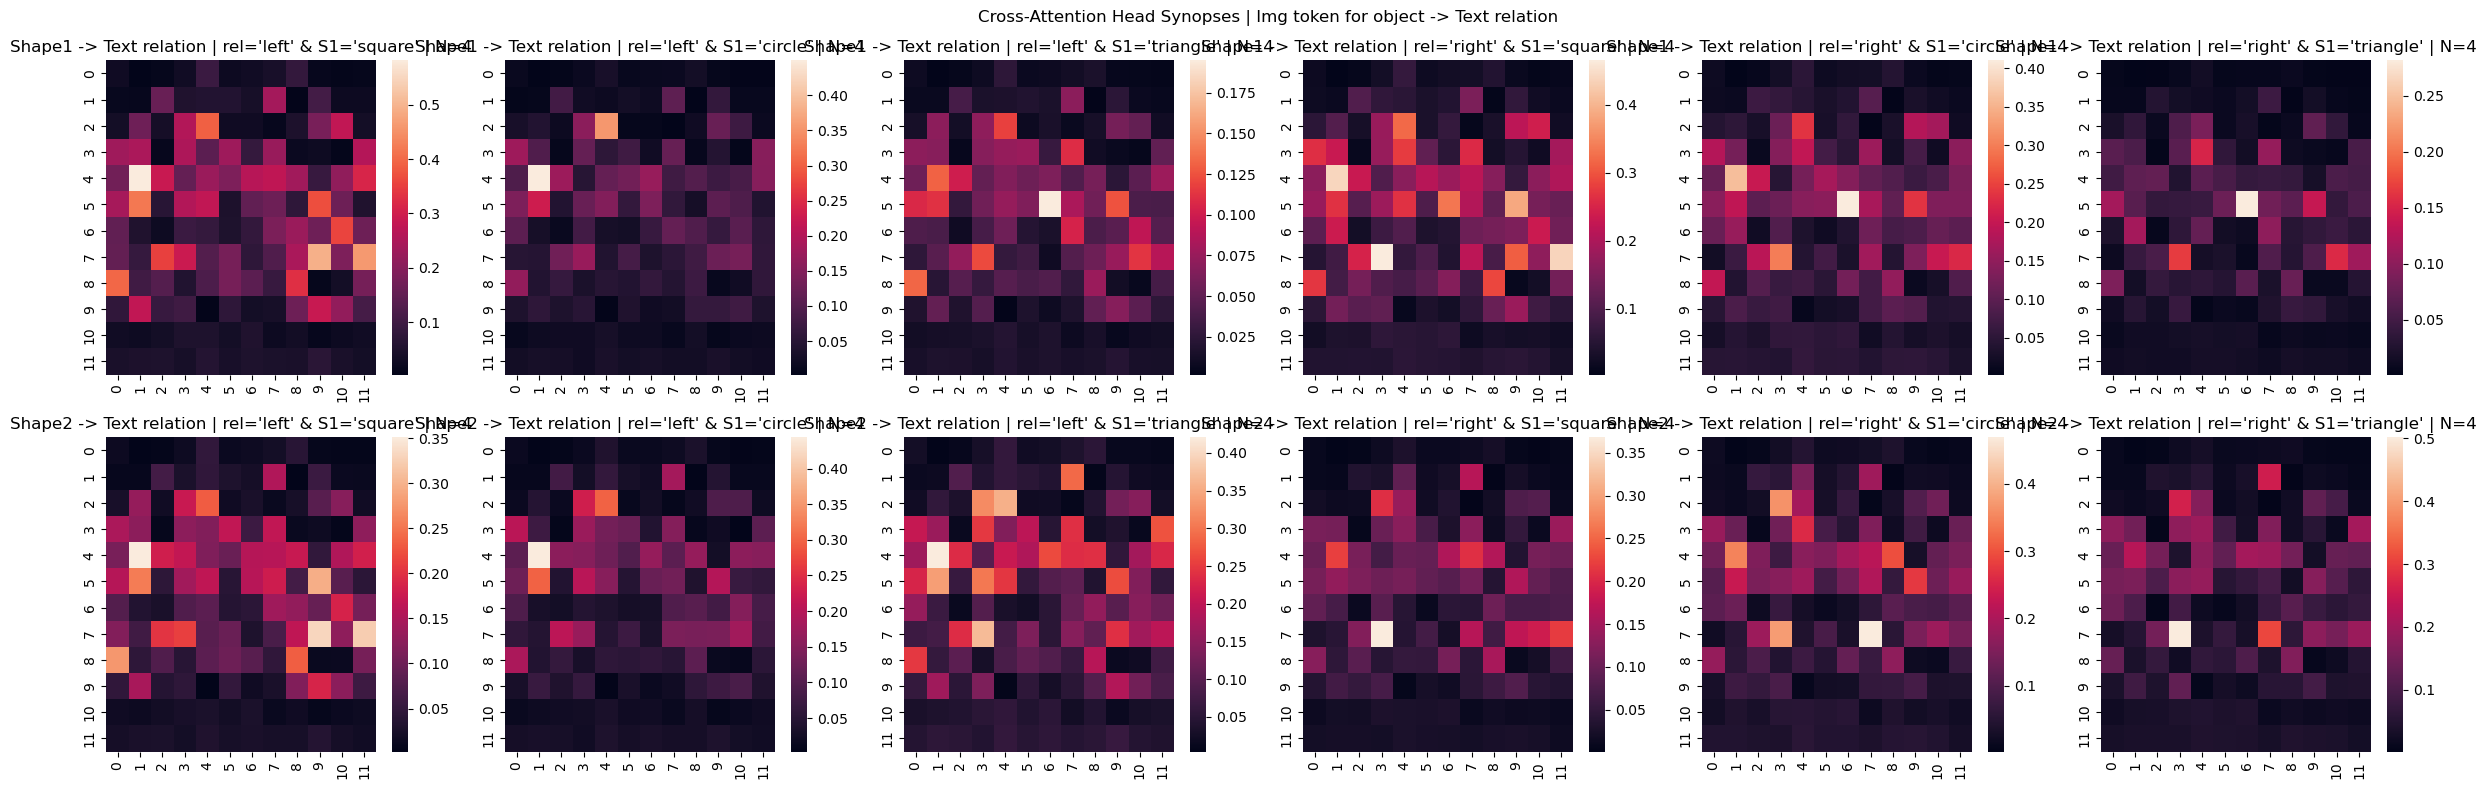

In [34]:
# img_src_str = "shape1"
# text_target_str = "relation"
fig, axs = plt.subplots(2, 6, figsize=(24, 8), )
for src_idx, img_src_str in enumerate(["shape1", "shape2"]):
    for query_idx, query_str in enumerate([
        "relation_str == 'left' and shape1 == 'square'",
        "relation_str == 'left' and shape1 == 'circle'",
        "relation_str == 'left' and shape1 == 'triangle'",
        "relation_str == 'right' and shape1 == 'square'",
        "relation_str == 'right' and shape1 == 'circle'",
        "relation_str == 'right' and shape1 == 'triangle'",
    ]):
        prompt_part_df = prompt_df.query(query_str)
        cond_stats_list = []
        for r_idx in range(len(prompt_part_df)):
            row = prompt_part_df.iloc[r_idx]
            prompt = row["prompt"]
            img_src = row[img_src_str] if img_src_str in row.keys() else img_src_str
            # text_target = row[text_target_str] if text_target_str in row.keys() else text_target_str
            text_target = row["relation"][-1] # "_".join(["below", "left", "top", "right", "above"]) #
            prompt_dir = join(figroot, prompt.replace(" ", "_"))
            attn_stats_file = join(prompt_dir, f"cross_attn_layer_head_step_stats_image_{img_src}_to_text_{text_target}.pt")
            attn_stats = th.load(attn_stats_file, weights_only=False)
            cond_stats = attn_stats["cond_stats"]
            cond_stats_list.append(cond_stats)

        cond_stats_array = np.stack(cond_stats_list, axis=0)
        plt.sca(axs[src_idx, query_idx])
        sns.heatmap(cond_stats_array.mean(axis=0))
        if src_idx == 0:
            plt.title(f"Shape1 -> Text relation | {query_str.replace(' == ', '=').replace('relation_str','rel').replace('shape1','S1').replace('shape2','S2').replace('and','&')} | N={len(prompt_part_df)}")
        else:
            plt.title(f"Shape2 -> Text relation | {query_str.replace(' == ', '=').replace('relation_str','rel').replace('shape1','S1').replace('shape2','S2').replace('and','&')} | N={len(prompt_part_df)}")
plt.suptitle("Cross-Attention Head Synopses | Img token for object -> Text relation", fontsize=12)
plt.tight_layout()
plt.show()